# Basic Image Manipulation

## Imports

In [10]:
import os
from typing import List, Literal

import cv2
from IPython import display
import matplotlib.pyplot as plt
import mmcv
import numpy as np
from numpy.typing import NDArray

## Constants

In [11]:
PROJECT_DIR = os.path.abspath('..')
IMAGES_DIR = os.path.join(PROJECT_DIR, "media")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "output")

## Functions

### Read/Write Images

In [12]:
def read_image(src_path: str, color_space: Literal['rgb', 'gray'] = 'rgb') -> NDArray[np.uint8]:
    """Reads an image into an array.
    
    Args:
        src_path (str): The absolute path to the image to read.
        color_space (Literal['rgb', 'gray']): The color space of the image to read.

    Returns:
        An array representing the image in RGB format.

    Raises:
        ValueError: Unrecognised argument for color space.
    """

    if color_space == 'rgb':
        image_bgr = cv2.imread(src_path)
        image = image_bgr.copy()
        image[:, :, 0] = image_bgr[:, :, 2]
        image[:, :, 2] = image_bgr[:, :, 0]
    elif color_space == 'gray':
        image = cv2.imread(src_path, 0)
        # image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f'Unrecognised color space argument {color_space}')
    return image

In [13]:
def write_image(dest_path: str, image: NDArray[np.uint8]) -> None:
    """Writes an array as an image file.
    
    Args:
        dest_path (str): The absolute path for the destination to write the image.
        image (NDArray[np.uint8]): A two/three dimensional array representing an image.

    Returns:
        None
    """

    if image.ndim == 3:
        image_bgr = image.copy()
        image_bgr[:, :, 0] = image[:, :, 2]
        image_bgr[:, :, 2] = image[:, :, 0]
        cv2.imwrite(dest_path, image_bgr)
    else:
        cv2.imwrite(dest_path, image)

In [14]:
def display_image(image: NDArray[np.uint8], title: str = '') -> None:
    """Displays the image represented by an array.

    Args:
        image (NDArray[np.uint8]): A two/three dimensional array representing an image.
        title (str): Title of the image.

    Returns:
        None
    """

    if image.ndim == 3:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [15]:
def resize_image(image: NDArray[np.uint8], new_height: int, new_width: int) -> NDArray[np.uint8]:
    """Resizes the width and height of an image.

    Args:
        image (NDArray[np.uint8]): A three dimensional array representing an image.
        new_height (int): Height of the output image.
        new_width (int): Width of the output image.

    Returns:
        A three dimensional array representing the resized image.
    """
    old_height, old_width, channels = image.shape
    output = np.zeros((new_height, new_width, channels), dtype=np.uint8)

    row_ratio = old_height / new_height
    col_ratio = old_width / new_width

    for idx in range(new_height):
        for jdx in range(new_width):
            xdx = int(idx * row_ratio)
            ydx = int(jdx * col_ratio)
            output[idx, jdx] = image[xdx, ydx]

    return output

### Read/Write Videos

In [16]:
def read_video(src_path: str) -> List[NDArray[np.uint8]]:
    """Reads a video as a list of arrays.

    Args:
        src_path (str): The absolute path to the video to read.

    Returns:
        A list of arrays representing the frames in RGB format.
    """

    video = mmcv.VideoReader(src_path)
    frames = []
    for frame in video:
        frame_rgb = frame.copy()
        frame_rgb[:, :, 0] = frame[:, :, 2]
        frame_rgb[:, :, 2] = frame[:, :, 0]
        frames.append(frame_rgb)
    return frames

In [17]:
def write_video(dest_path: str, video: List[NDArray[np.uint8]], fps: int = 25) -> None:
    """Writes a video to a file.

    Args:
        dest_path (str): The absolute path for the destination to write the video.
        video (List[NDArray[np.uint8]]): A three dimensional array representing frames of a video.
        fps (int): Number of frames to fit in one second.

    Returns:
        None
    """

    height, width, _ = video[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output = cv2.VideoWriter(dest_path, fourcc, fps, (width, height))
    for frame in video:
        frame_bgr = frame.copy()
        frame_bgr[:, :, 0] = frame[:, :, 2]
        frame_bgr[:, :, 2] = frame[:, :, 0]
        output.write(frame_bgr)
    output.release()

In [18]:
def display_video(src_path: str) -> None:
    """Displays a video stored locally.

    Args:
        src_path (str): The absolute path to the video to display.

    Returns:
        None
    """

    video = f'''
    <video width="720" controls>
        <source src="{src_path}" type="video/mp4">
    </video>
    '''
    return display.HTML(video)

### Image Manipulation

In [19]:
def change_brightness(image: NDArray[np.uint8], method: Literal['multiply', 'add'] = 'multiply', change: float = 0) -> NDArray[np.uint8]:
    """Changes the brightness of an image.

    Changes the brightness of an image by adding or multiplying to the original intensities.

    Args:
        image (NDArray[np.uint8]): A two/three dimensional array representing an image.
        method (Literal['multiply', 'add']): The method of increasing brightness.
        change (float): The operand to be used with the method.

    Returns:
        A two/three dimensional array representing the brightness adjusted image.

    Raises:
        ValueError: Unrecognised argument for method.
    """

    output = image.copy().astype(np.float64)
    if method == 'multiply':
        output = output * change
    elif method == 'add':
        output = output + change
    else:
        raise ValueError(f'Unrecognised method {method}')

    output = np.round(output)
    output = np.clip(output, 0, 255)
    output = output.astype(np.uint8)
    return output

In [20]:
def increase_contrast(image: NDArray[np.uint8], threshold: float = 1.5) -> NDArray[np.uint8]:
    """Increases the contrast of an image.

    Increases the contrast of an image, by remapping intensities to span the (0, 255) range.

    Args:
        image (NDArray[np.uint8]): A two/three dimensional array representing an image.

    Returns:
        A two/three dimensional array representing the contrast adjusted image.
    """

    output = image.copy().astype(np.float64)
    min_value = np.percentile(output, threshold)
    max_value = np.percentile(output, 100 - threshold)
    output = output - min_value
    output = output * 255 / (max_value - min_value)

    output = np.round(output)
    output = np.clip(output, 0, 255)
    output = output.astype(np.uint8)
    return output

In [21]:
def grayscale_conversion(image: NDArray[np.uint8], method: Literal['mean', 'BT.601', 'BT.709'] = 'mean') -> NDArray[np.uint8]:
    """Converts a color image to grayscale.

    Args:
        image (NDArray[np.uint8]): A three dimensional array representing a RGB image.
        method (Literal['mean', 'BT.601', 'BT.709:']): Conversion formulas to choose from.

    Returns:
        A two dimensional array representing the grayscale image.

    Raises:
        ValueError: Unrecognised argument for method.
    """

    # Ref: https://stackoverflow.com/a/596241
    image_float = image.astype(np.float64)
    if method == 'mean':
        output = 0.33 * image_float[:, :, 0] + 0.33 * image_float[:, :, 1] + 0.33 * image_float[:, :, 2]
    elif method == 'BT.601':
        output = 0.299 * image_float[:, :, 0] + 0.587 * image_float[:, :, 1] + 0.114 * image_float[:, :, 2]
    elif method == 'BT.709':
        output = 0.2126 * image_float[:, :, 0] + 0.7152* image_float[:, :, 1] + 0.0722 * image_float[:, :, 2]
    else:
        raise ValueError(f'Unrecognised method {method}')

    output = np.round(output)
    output = np.clip(output, 0, 255)
    output = output.astype(np.uint8)
    return output

In [22]:
def pseudo_color_mapping(image: NDArray[np.uint8]) -> NDArray[np.uint8]:
    """Applies a pseudo color mapping to a grayscale image.

    Args:
        image (NDArray[np.uint8]): A two dimensional array representing a grayscale image.

    Returns:
        A three dimensional array representing the pseudo colored RGB image.
    """

    height, width = image.shape
    output = np.empty((height, width, 3), dtype=np.float64)
    image_float = image.astype(np.float64)

    color1 = np.array([255, 103, 31], dtype=np.float64)
    color2 = np.array([4, 106, 56], dtype=np.float64)

    for idx in range(height):
        for jdx in range(width):
            alpha = float(idx) * float(jdx) / (height * width)
            color = alpha * color1 + (1 - alpha) * color2
            output[idx, jdx] = (image_float[idx, jdx] / 255) * color

    output = np.round(output)
    output = np.clip(output, 0, 255)
    output = output.astype(np.uint8)
    return output

In [23]:
def chroma_keying(foreground: NDArray[np.uint8], background: NDArray[np.uint8], threshold: float = 2) -> NDArray[np.uint8]:
    """Merges foreground image into background of equal size, in the absence of green.

    Args:
        foreground (NDArray[np.uint8]): A three dimensional array representing a RGB image.
        background (NDArray[np.uint8]): A three dimensional array representing a RGB image.
        threshold (float): The ratio between green and red/blue to base filter upon.

    Returns:
        A three dimensional array representing the merged RGB image.
    """

    output = background.copy()
    for i in range(foreground.shape[0]):
        for j in range(foreground.shape[1]):
            red, green, blue = foreground[i, j].astype(np.float64)
            if green < threshold * red or green < threshold * blue:
                output[i, j] = foreground[i, j]
    return output

In [24]:
def fade_transition(image1: NDArray[np.uint8], image2: NDArray[np.uint8], num_frames=25) -> List[NDArray[np.uint8]]:
    """Merges foreground image into background in the absence of green.

    Args:
        foreground (NDArray[np.uint8]): A three dimensional array representing a RGB image.
        background (NDArray[np.uint8]): A three dimensional array representing a RGB image.
        num_frames (int): Number of intermediate frames to generate.

    Returns:
        A three dimensional array representing the merged RGB image.
    """

    image1_float = image1.astype(np.float64)
    image2_float = image2.astype(np.float64)

    video = []
    for idx in range(num_frames):
        alpha = idx / (num_frames - 1)
        frame = (1 - alpha) * image1_float + alpha * image2_float

        frame = np.round(frame)
        frame = np.clip(frame, 0, 255)
        frame = frame.astype(np.uint8)
        video.append(frame)
    return video

## Demonstration

### Brightness Control

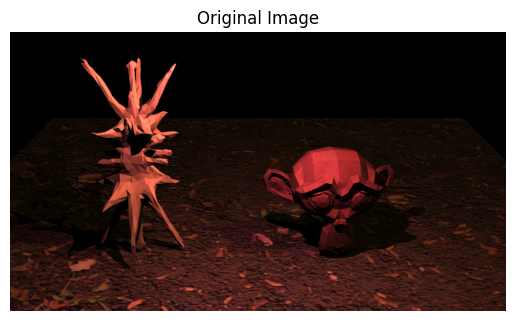

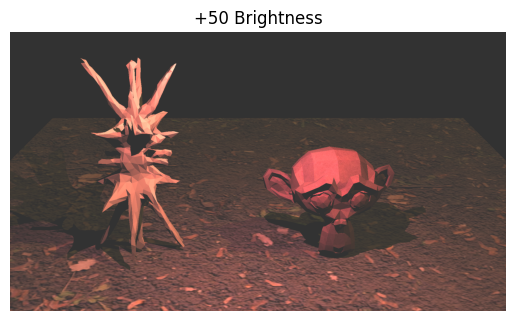

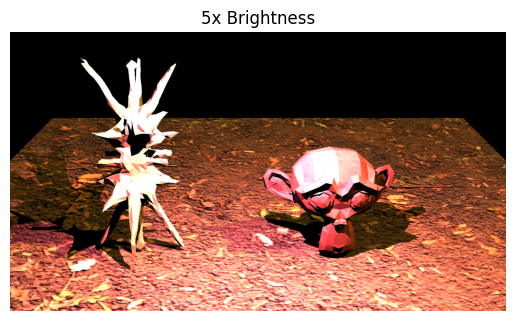

In [25]:
monkey = read_image(f'{IMAGES_DIR}/monkey.png')
display_image(monkey, 'Original Image')

monkey_added_brightness = change_brightness(monkey, 'add', 50)
display_image(monkey_added_brightness, '+50 Brightness')
write_image(f'{OUTPUT_DIR}/monkey_added_brightness.jpg', monkey_added_brightness)

monkey_multiplied_brightness = change_brightness(monkey, 'multiply', 5)
display_image(monkey_multiplied_brightness, '5x Brightness')
write_image(f'{OUTPUT_DIR}/monkey_multiplied_brightness.jpg', monkey_multiplied_brightness)

### Contrast Stretching

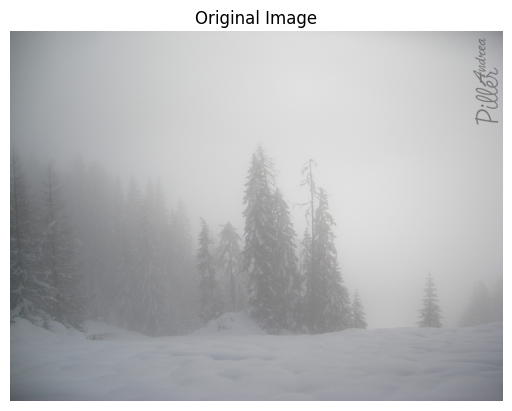

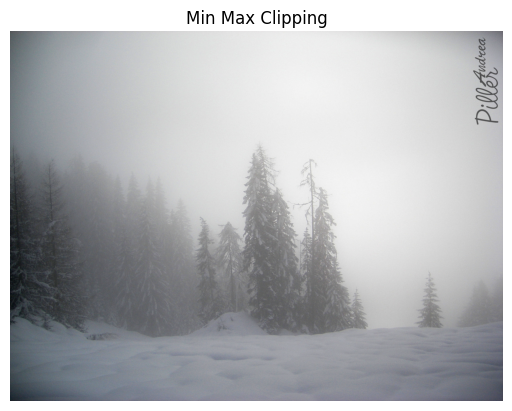

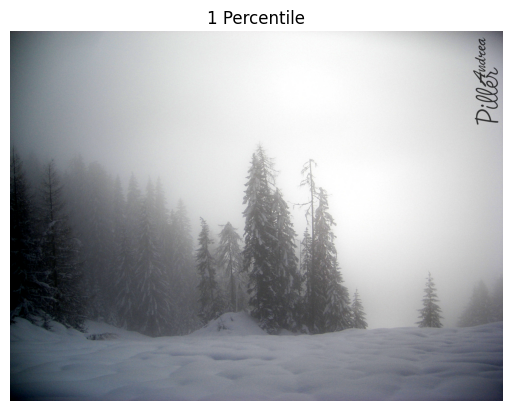

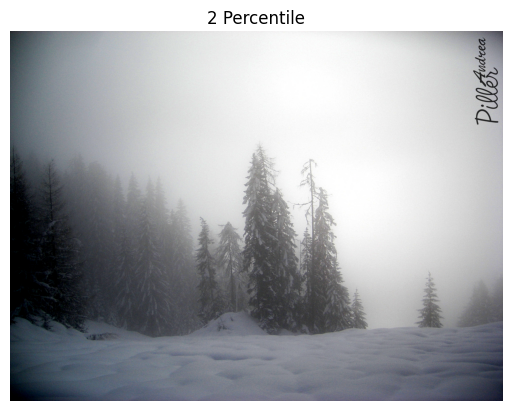

In [26]:
fog = read_image(f'{IMAGES_DIR}/fog.jpg')
display_image(fog, 'Original Image')

fog_contrast = increase_contrast(fog, threshold=0)
display_image(fog_contrast, 'Min Max Clipping')
write_image(f'{OUTPUT_DIR}/fog_contrast.jpg', fog_contrast)

fog_contrast_1= increase_contrast(fog, threshold=1)
display_image(fog_contrast_1, '1 Percentile')
write_image(f'{OUTPUT_DIR}/fog_contrast_1.jpg', fog_contrast_1)

fog_contrast_2 = increase_contrast(fog, threshold=2)
display_image(fog_contrast_2, '2 Percentile')
write_image(f'{OUTPUT_DIR}/fog_contrast_2.jpg', fog_contrast_2)

### Grayscale Conversion

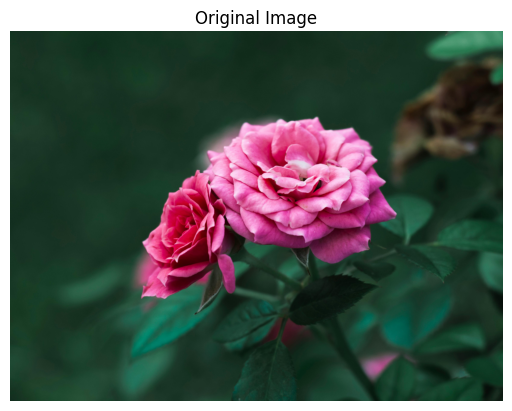

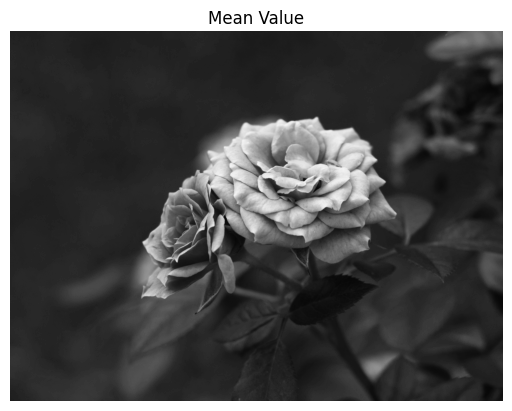

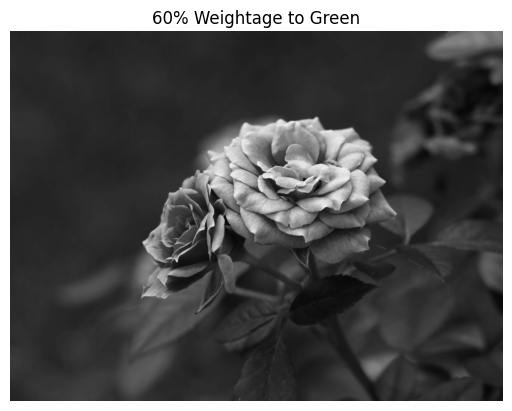

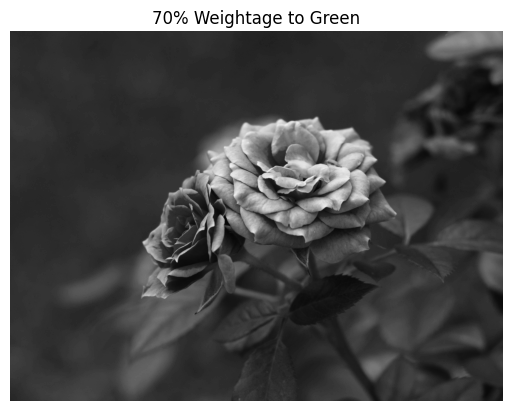

In [27]:
rose = read_image(f'{IMAGES_DIR}/rose.jpg')
display_image(rose, 'Original Image')

rose_grayscale_33 = grayscale_conversion(rose, method='mean')
display_image(rose_grayscale_33, 'Mean Value')
write_image(f'{OUTPUT_DIR}/rose_grayscale_33.jpg', rose_grayscale_33)

rose_grayscale_60 = grayscale_conversion(rose, method='BT.601')
display_image(rose_grayscale_60, '60% Weightage to Green')
write_image(f'{OUTPUT_DIR}/rose_grayscale_60.jpg', rose_grayscale_60)

rose_grayscale_70 = grayscale_conversion(rose, method='BT.709')
display_image(rose_grayscale_70, '70% Weightage to Green')
write_image(f'{OUTPUT_DIR}/rose_grayscale_70.jpg', rose_grayscale_70)

### Pseudo Color Mapping

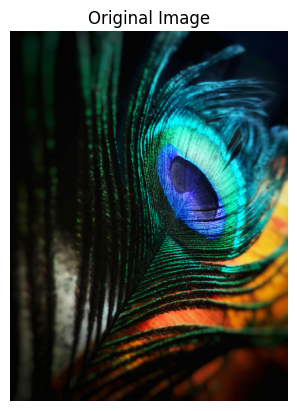

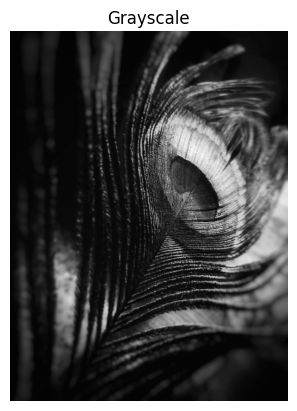

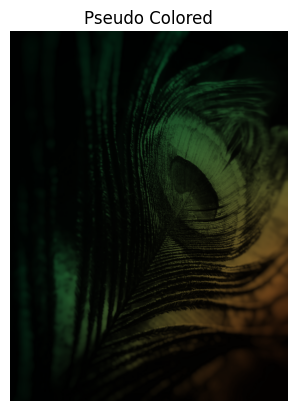

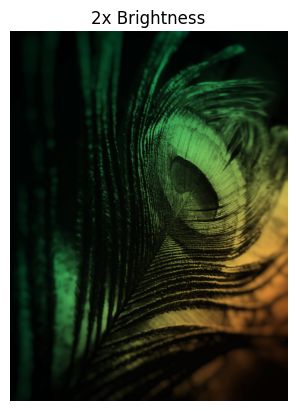

In [28]:
feather = read_image(f'{IMAGES_DIR}/feather.jpg')
display_image(feather, 'Original Image')

feather_grayscale = grayscale_conversion(feather, method='BT.709')
display_image(feather_grayscale, 'Grayscale')
write_image(f'{OUTPUT_DIR}/feather_grayscale.jpg', feather_grayscale)

feather_pseudo_colored = pseudo_color_mapping(feather_grayscale)
display_image(feather_pseudo_colored, 'Pseudo Colored')
write_image(f'{OUTPUT_DIR}/feather_pseudo_colored.jpg', feather_pseudo_colored)

feather_brightness_adjusted = change_brightness(feather_pseudo_colored, 'multiply', 2)
display_image(feather_brightness_adjusted, '2x Brightness')
write_image(f'{OUTPUT_DIR}/feather_brightness_adjusted.jpg', feather_brightness_adjusted)

### Chroma Keying

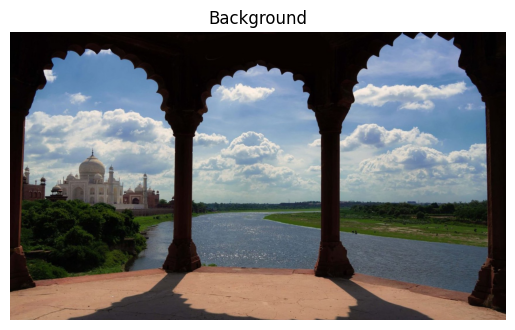

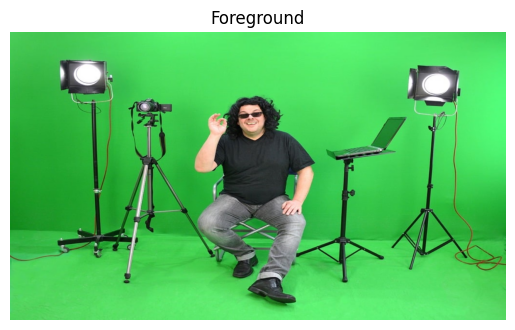

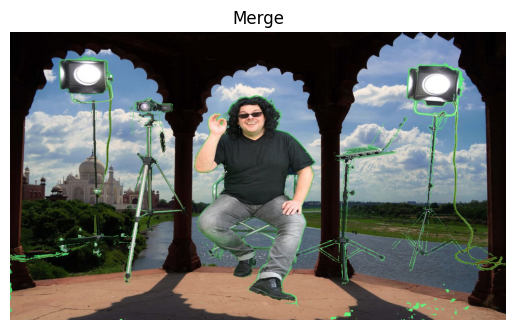

In [29]:
tajmahal = read_image(f'{IMAGES_DIR}/tajmahal.jpg')
display_image(tajmahal, 'Background')

director = read_image(f'{IMAGES_DIR}/greenbox-director.jpg')
director = resize_image(director, tajmahal.shape[0], tajmahal.shape[1])
display_image(director, 'Foreground')

merge = chroma_keying(director, tajmahal)
display_image(merge, 'Merge')
write_image(f'{OUTPUT_DIR}/chroma_keying.jpg', merge)

### Fade Transition

In [30]:
video = fade_transition(director, merge)
write_video(f'{OUTPUT_DIR}/fade_transition.mp4', video)

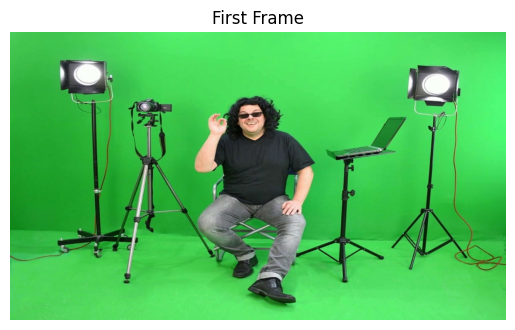

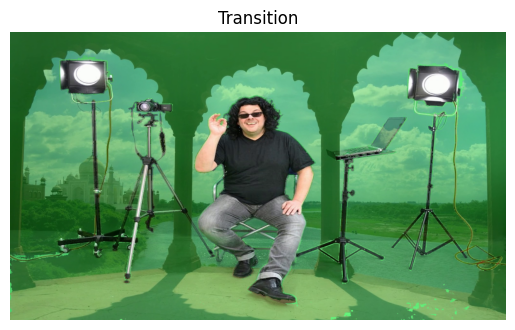

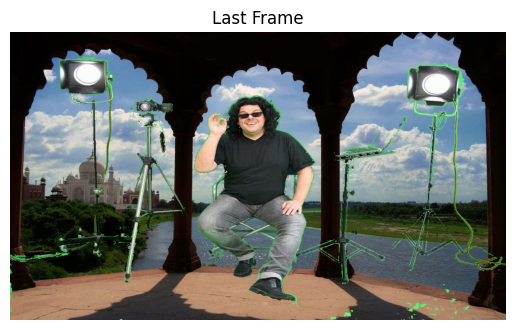

In [31]:
video = read_video(f'{OUTPUT_DIR}/fade_transition.mp4')

display_image(video[0], 'First Frame')
write_image(f'{OUTPUT_DIR}/fade_transition_1.jpg', video[0])

display_image(video[12], 'Transition')
write_image(f'{OUTPUT_DIR}/fade_transition_13.jpg', video[12])

display_image(video[-1], 'Last Frame')
write_image(f'{OUTPUT_DIR}/fade_transition_25.jpg', video[-1])

In [32]:
display_video(f'{OUTPUT_DIR}/fade_transition.mp4')